## Analyse IRM_Marche Moteur
--
Parcellation en 444 regions (BASC Atlas) --> SEULEMENT Moteur

Classification : SVM Linéaire

Patients

In [1]:
import numpy as np
from scipy.stats import binom_test
from sklearn.pipeline import Pipeline   
from sklearn.svm import SVC
from sklearn import preprocessing 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
from nilearn.datasets import load_mni152_brain_mask
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from sklearn.cross_validation import LeaveOneLabelOut, cross_val_score, permutation_test_score
from sklearn.externals.joblib import Memory
%matplotlib inline
from nilearn.plotting import plot_stat_map
import sys
sys.path[0]='Z:/GitHub/gsp-learn/'
from gsplearn.GSPTransform import GraphTransformer
from gsplearn.GSPPlot import plot_selectedregions

C:\Users\mmenoret\Miniconda2\envs\fmri_3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
motor_label=np.fromfile('F:/IRM_Marche/masquesROI/reg_sma_basc444asym.np','int')
#motor_label=np.arange(410,444)
fold='F:/IRM_marche/all_mni_imp_imag/'
smt='ss'       
names=('69','54','45','53','63','55','59','70','51','52','61','49','46','64','56','50','65','57',
       '62','48','43','68','42','67','47','60','41','44','66','58' )

scaler = preprocessing.StandardScaler()
svm= SVC(C=1., kernel="linear")  
pipeline = Pipeline([('scale', scaler),('svm', svm)])
k=50 #best 52
feature_selection = SelectKBest(f_classif, k=k)   
pipeline_anova = Pipeline([('anova', feature_selection), ('scale', scaler),('svm', svm)])

block=np.loadtxt(fold+'block.txt','int')
label=np.loadtxt(fold+'label.txt','S12')

mask_block=block==block
for x in range(label.shape[0]):
    if label[x]!=label[x-1]:
        mask_block[x]=False
    elif label[x]!=label[x-2]:
        mask_block[x]=False

condition_imp = np.logical_or(label == b'restimp', label == b'imp')
mask_imp= np.logical_and(condition_imp,mask_block)
condition_imag = np.logical_or(label == b'restimag', label == b'imag')
mask_imag= np.logical_and(condition_imag,mask_block)

y_imp = label[mask_imp]
y_imag = label[mask_imag]
block_cond = block[mask_imp]
cv = LeaveOneLabelOut(block_cond)
scores_imp=[]
scores_imag=[]
result_tr_imp=[]
result_tr_imag=[]
roi_imp_all=np.zeros([0,len(motor_label)])
roi_imag_all=np.zeros([0,len(motor_label)])
#roi_imp_all=np.zeros([0,444])
#roi_imag_all=np.zeros([0,444])
y_imp_all=np.zeros(0)
y_imag_all=np.zeros(0)

for i,n in enumerate(sorted(names)):
    roi_name=fold+'asymroi_'+smt+'_'+n+'.npz'              
    roi=np.load(roi_name)['roi']
    roi=roi[:,motor_label-1]
    roi_imp=roi[mask_imp]
    roi_imag=roi[mask_imag]
    roi_imp_all=np.vstack((roi_imp_all,roi_imp))
    roi_imag_all=np.vstack((roi_imag_all,roi_imag))
    y_imp_all=np.append(y_imp_all,y_imp)
    y_imag_all=np.append(y_imag_all,y_imag)
    scores_imp_cv = cross_val_score(
                                pipeline, roi_imp, y_imp,cv=cv)
    scores_imp.append(scores_imp_cv.mean())
    scores_imag_cv = cross_val_score(
                                pipeline, roi_imag, y_imag,cv=cv)
    scores_imag.append(scores_imag_cv.mean())
    pipeline.fit(roi_imp,y_imp)
    prediction = pipeline.predict(roi_imag)  
    result_tr_imp.append(accuracy_score(prediction,y_imp))
    pipeline.fit(roi_imag,y_imag)
    prediction = pipeline.predict(roi_imp)  
    result_tr_imag.append(accuracy_score(prediction,y_imag))

    print(n,scores_imp[i],scores_imag[i],result_tr_imp[i],result_tr_imag[i])
    ### Permutation (random par sujet)
   # nb_p=1000
   #null_result_tr_imag=np.zeros(nb_p)
   # null_result_tr_imp=np.zeros(nb_p)
   # for z in range(nb_p):
   #     suj_train_random=np.random.permutation(y_imp)
            
   #     pipeline.fit(roi_imp, suj_train_random)
   #     prediction = pipeline.predict(roi_imag) 
   #     null_result_tr_imp[z]=accuracy_score(prediction,y_imp)
    
   #     pipeline.fit(roi_imag, suj_train_random)
   #     prediction = pipeline.predict(roi_imp) 
   #     null_result_tr_imag[z]=accuracy_score(prediction,y_imp)

  #  sign_tr_imag=(null_result_tr_imag>=result_tr_imag[i]).sum()/nb_p
   # sign_tr_imp=(null_result_tr_imp>=result_tr_imp[i]).sum()/nb_p
   # print('tr_imp',sign_tr_imp,'tr_imag',sign_tr_imag)
print(np.array(scores_imp).mean(),np.array(scores_imag).mean(),np.array(result_tr_imp).mean(),np.array(result_tr_imag).mean())



41 0.685185185185 0.633190883191 0.552631578947 0.552631578947
42 0.798433048433 0.658831908832 0.587719298246 0.552631578947
43 0.684472934473 0.709401709402 0.59649122807 0.543859649123
44 0.566951566952 0.683760683761 0.657894736842 0.587719298246
45 0.527065527066 0.77849002849 0.552631578947 0.464912280702
46 0.625356125356 0.632478632479 0.570175438596 0.622807017544
47 0.606125356125 0.641025641026 0.535087719298 0.535087719298
48 0.762820512821 0.659544159544 0.605263157895 0.59649122807
49 0.65811965812 0.718660968661 0.666666666667 0.570175438596
50 0.866809116809 0.587606837607 0.5 0.473684210526
51 0.45584045584 0.659544159544 0.59649122807 0.535087719298
52 0.712250712251 0.608974358974 0.561403508772 0.614035087719
53 0.507122507123 0.652421652422 0.40350877193 0.464912280702
54 0.64886039886 0.56339031339 0.587719298246 0.552631578947
55 0.678774928775 0.728632478632 0.324561403509 0.429824561404
56 0.676638176638 0.675925925926 0.491228070175 0.517543859649
57 0.6930199

In [7]:
coef_tr_imag=np.zeros([1,444])
coef_tr_imp=np.zeros([1,444])
#pipeline_anova.fit(roi_imag_all,y_imag_all)
pipeline.fit(roi_imag_all,y_imag_all)
#coef = pipeline_anova.named_steps['svm'].coef_
coef = pipeline.named_steps['svm'].coef_
#coef = pipeline_anova.named_steps['anova'].inverse_transform(coef)

for i,n in enumerate(motor_label):
    coef_tr_imag[0,n-1]=coef[0,i]
#coef_tr_imag=coef
#prediction = pipeline_anova.predict(roi_imp_all)  
prediction = pipeline.predict(roi_imp_all)  
print('p tr imag', binom_test((prediction==y_imag_all).sum(),n=len(y_imag_all),p=0.5))

result_tr_imag_all=accuracy_score(prediction,y_imag_all)

#pipeline_anova.fit(roi_imp_all,y_imp_all)
pipeline.fit(roi_imp_all,y_imp_all)
#coef = pipeline_anova.named_steps['svm'].coef_
coef = pipeline.named_steps['svm'].coef_
#coef = pipeline_anova.named_steps['anova'].inverse_transform(coef)
for i,n in enumerate(motor_label):
    coef_tr_imp[0,n-1]=coef[0,i]
#coef_tr_imp=coef
#prediction = pipeline_anova.predict(roi_imag_all)  
prediction = pipeline.predict(roi_imag_all)  
result_tr_imp_all=accuracy_score(prediction,y_imp_all)
print('p tr imp', binom_test((prediction==y_imp_all).sum(),n=len(y_imp_all),p=0.5))

print('All','train imag',result_tr_imag_all,'train imp',result_tr_imp_all)


p tr imag 2.826099052e-24
p tr imp 1.115568337e-18
All train imag 0.586842105263 train imp 0.575438596491


Visualisation des poids du SVM (regions qui permettent la classification): sur classif globale

C:\Users\mmenoret\Miniconda2\envs\fmri_3\lib\site-packages\scipy\ndimage\interpolation.py:462: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


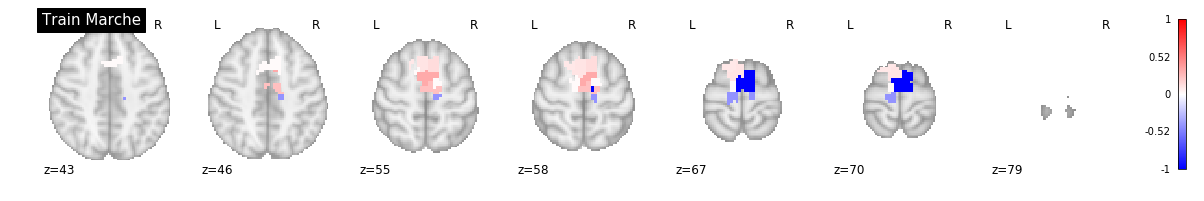

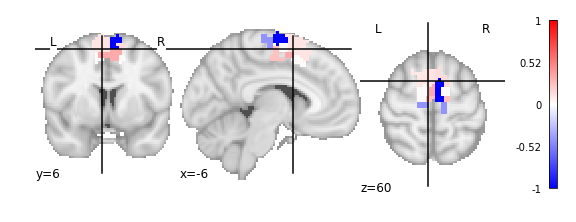

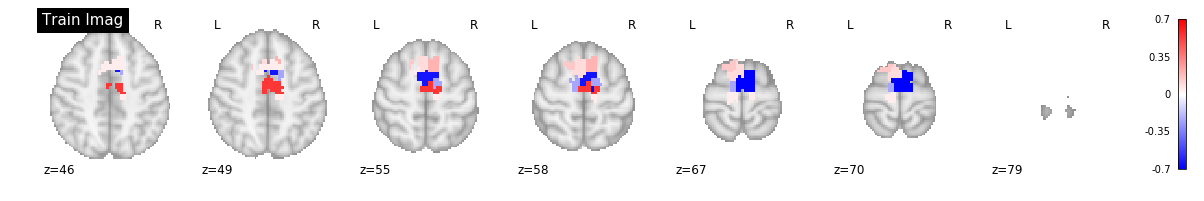

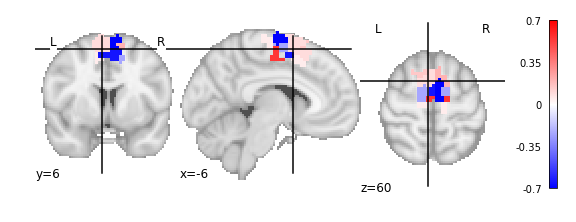

In [8]:

mem = Memory('nilearn_cache')
basc = datasets.fetch_atlas_basc_multiscale_2015(version='asym')['scale444']

brainmask = load_mni152_brain_mask()
masker = NiftiLabelsMasker(labels_img = basc, mask_img = brainmask, 
                           memory=mem, memory_level=1, verbose=0,
                           detrend=False, standardize=False,  
                           high_pass=0.01,t_r=2.28,
                           resampling_target='labels')
masker.fit()

weight_img_trimp = masker.inverse_transform(coef_tr_imp)
plot_stat_map(weight_img_trimp, title='Train Marche',display_mode='z',cmap='bwr')
plot_stat_map(weight_img_trimp,cmap='bwr', cut_coords=[-6, 6, 60])
weight_img_trimag = masker.inverse_transform(coef_tr_imag)
plot_stat_map(weight_img_trimag, title='Train Imag',display_mode='z',cmap='bwr')
plot_stat_map(weight_img_trimag,cmap='bwr', cut_coords=[-6, 6, 60])

In [9]:
### Permutation (random par sujet)
nb_p=1000
null_result_tr_imag=np.zeros(nb_p)
null_result_tr_imp=np.zeros(nb_p)
nb_s=len(names)
for i in range(nb_p):
    y_train_random=np.zeros((0,1),dtype='S12')
    for suj in range(nb_s):
        suj_train_random=np.random.permutation(y_imp)
        y_train_random=np.append(y_train_random,suj_train_random)

        
    pipeline.fit(roi_imp_all, y_train_random)
    prediction = pipeline.predict(roi_imag_all) 
    null_result_tr_imp[i]=accuracy_score(prediction,y_imp_all)
    
    pipeline.fit(roi_imag_all, y_train_random)
    prediction = pipeline.predict(roi_imp_all) 
    null_result_tr_imag[i]=accuracy_score(prediction,y_imp_all)

sign_tr_imag=(null_result_tr_imag>=result_tr_imag_all).sum()/nb_p
sign_tr_imp=(null_result_tr_imp>=result_tr_imp_all).sum()/nb_p
print('tr_imag',sign_tr_imag,'tr_imp',sign_tr_imp)

tr_imag 0.056 tr_imp 0.089


# Apprentissage sur tous - test indiv

In [9]:
result_tr_imp=[]
result_tr_imag=[]
nb_s=len(names)
nb_p=1000
null_result_tr_imag=np.zeros((nb_s,nb_p))
null_result_tr_imp=np.zeros((nb_s,nb_p))
for i,n in enumerate(sorted(names)):
    roi_name=fold+'asymroi_'+smt+'_'+n+'.npz'              
    roi=np.load(roi_name)['roi']
    roi=roi[:,motor_label-1]
    roi_imp=roi[mask_imp]
    roi_imag=roi[mask_imag]
    pipeline.fit(roi_imp_all,y_imp_all)    
    prediction = pipeline.predict(roi_imag)  
    result_tr_imp.append(accuracy_score(prediction,y_imp))
    pipeline.fit(roi_imag_all,y_imag_all)
    prediction = pipeline.predict(roi_imp)  
    result_tr_imag.append(accuracy_score(prediction,y_imag))
    
for z in range(nb_p):
    y_train_random=np.zeros((0,1),dtype='S12')
    for suj in range(nb_s):
        suj_train_random=np.random.permutation(y_imp)
        y_train_random=np.append(y_train_random,suj_train_random) 
    pipeline.fit(roi_imp_all, y_train_random)        
    for i,n in enumerate(sorted(names)):
        roi_name=fold+'asymroi_'+smt+'_'+n+'.npz'              
        roi=np.load(roi_name)['roi']
        roi=roi[:,motor_label-1]
        roi_imp=roi[mask_imp]
        roi_imag=roi[mask_imag]        
        prediction = pipeline.predict(roi_imag) 
        null_result_tr_imp[i,z]=accuracy_score(prediction,y_imp)
        
    pipeline.fit(roi_imag_all, y_train_random)    
    for i,n in enumerate(sorted(names)):
        roi_name=fold+'asymroi_'+smt+'_'+n+'.npz'              
        roi=np.load(roi_name)['roi']
        roi=roi[:,motor_label-1]
        roi_imp=roi[mask_imp]
        roi_imag=roi[mask_imag]   
        prediction = pipeline.predict(roi_imp) 
        null_result_tr_imag[i,z]=accuracy_score(prediction,y_imp)

for i,n in enumerate(sorted(names)):        
    sign_tr_imag=(null_result_tr_imag[i,:]>=result_tr_imag[i]).sum()/nb_p
    sign_tr_imp=(null_result_tr_imp[i,:]>=result_tr_imp[i]).sum()/nb_p
    print(n,'tr_imp',result_tr_imp[i],'tr_imp',sign_tr_imp,'tr_imag',result_tr_imag[i],'tr_imag',sign_tr_imag)






af tr_imp 0.587719298246 tr_imp 0.191 tr_imag 0.526315789474 tr_imag 0.386
an tr_imp 0.429824561404 tr_imp 0.81 tr_imag 0.631578947368 tr_imag 0.055
ap tr_imp 0.377192982456 tr_imp 0.977 tr_imag 0.59649122807 tr_imag 0.137
as tr_imp 0.543859649123 tr_imp 0.385 tr_imag 0.587719298246 tr_imag 0.209
ba tr_imp 0.421052631579 tr_imp 0.786 tr_imag 0.40350877193 tr_imag 0.848
be tr_imp 0.324561403509 tr_imp 0.978 tr_imag 0.570175438596 tr_imag 0.285
bh tr_imp 0.482456140351 tr_imp 0.624 tr_imag 0.482456140351 tr_imag 0.649
bi tr_imp 0.482456140351 tr_imp 0.58 tr_imag 0.429824561404 tr_imag 0.846
bm tr_imp 0.394736842105 tr_imp 0.821 tr_imag 0.552631578947 tr_imag 0.36
boh tr_imp 0.526315789474 tr_imp 0.434 tr_imag 0.570175438596 tr_imag 0.293
br tr_imp 0.614035087719 tr_imp 0.14 tr_imag 0.649122807018 tr_imag 0.119
cas tr_imp 0.552631578947 tr_imp 0.341 tr_imag 0.754385964912 tr_imag 0.008
cb tr_imp 0.561403508772 tr_imp 0.292 tr_imag 0.561403508772 tr_imag 0.33
cc tr_imp 0.456140350877 tr_im

In [10]:

from sklearn.dummy import DummyClassifier
nb_p=1000
dumsco=np.zeros(nb_p)
dummy=DummyClassifier()
dummy.fit(roi_imp_all,y_imp_all) 
for n in range(nb_p):
    dumsco[n]=dummy.score(roi_imag_all,y_imp_all)

print(dumsco.mean(),dumsco.max(),dumsco.min())

0.500320398454 0.52155813262 0.478293190604


In [11]:

result_tr_imp=[]
result_tr_imag=[]
stat_trimp=[]
stat_trimag=[]
for i,n in enumerate(sorted(names)):
    roi_name=fold+'asymroi_'+smt+'_'+n+'.npz'              
    roi=np.load(roi_name)['roi']
    roi=roi[:,motor_label-1]
    roi_imp=roi[mask_imp]
    roi_imag=roi[mask_imag]
    pipeline.fit(roi_imp_all,y_imp_all)    
    prediction = pipeline.predict(roi_imag) 
    stat_trimp.append(binom_test((prediction==y_imp).sum(),n=len(y_imp),p=0.5))
    result_tr_imp.append(accuracy_score(prediction,y_imp))
    pipeline.fit(roi_imag_all,y_imag_all)
    prediction = pipeline.predict(roi_imp)  
    result_tr_imag.append(accuracy_score(prediction,y_imag))
    stat_trimag.append(binom_test((prediction==y_imag).sum(),n=len(y_imag),p=0.5))
    print(n,'tr_imp',result_tr_imp[i],stat_trimp[i],'tr_imag',result_tr_imag[i],stat_trimag[i])
       
    

af tr_imp 0.587719298246 0.0746925300798 tr_imag 0.526315789474 0.639769368643
an tr_imp 0.429824561404 0.159761507785 tr_imag 0.631578947368 0.0063516239199
ap tr_imp 0.377192982456 0.0111185934488 tr_imag 0.59649122807 0.0487246863987
as tr_imp 0.543859649123 0.399373186881 tr_imag 0.587719298246 0.0746925300798
ba tr_imp 0.421052631579 0.110939311885 tr_imag 0.40350877193 0.0487246863987
be tr_imp 0.324561403509 0.000226811032333 tr_imag 0.570175438596 0.159761507785
bh tr_imp 0.482456140351 0.778876092003 tr_imag 0.482456140351 0.778876092003
bi tr_imp 0.482456140351 0.778876092003 tr_imag 0.429824561404 0.159761507785
bm tr_imp 0.394736842105 0.0307763238544 tr_imag 0.552631578947 0.30287755263
boh tr_imp 0.526315789474 0.639769368643 tr_imag 0.570175438596 0.159761507785
br tr_imp 0.614035087719 0.0188107488249 tr_imag 0.649122807018 0.00186671822732
cas tr_imp 0.552631578947 0.30287755263 tr_imag 0.754385964912 4.84213260285e-08
cb tr_imp 0.561403508772 0.223230362456 tr_imag 0.

In [12]:
len(prediction==y_imp)


114